# Fitting and Forecasting Populating Growth

In [1]:
# -- Imports --
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## -- Setup --

# Fetch the data.
df = pd.read_csv("https://ourworldindata.org/grapher/population.csv?v=1&csvType=full&useColumnShortNames=true", 
    storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/population.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

In [3]:
# -- Data Processing --

df = df[df['Entity'] == 'World'] # Filter for World population
df = df[df['Year'] >= 1923] # Last 100 years
df = df.drop(labels=['Code'], axis=1) # drop the code column, as it isnt needed

# extract values
years = years = df['Year'].values
population = df['population_historical'].values 

In [4]:
# -- Sampling --

cutoff = max(years) - 10 # Get years up, removing 10 years latest
train_mask = years <= cutoff # Initialise the mask

# Apply mask to filter out last 10 years for both x and y
years_train = years[train_mask]
population_train = population[train_mask]

In [5]:

# -- Fitting --

fits = {} # Dict store for polynomial coefficients for each degree
for degree in range(1, 10): # Polynomials of degree 1 - 9
    coef = np.polyfit(x=years_train, y=population_train, deg=degree) # find polynomial curve that best matches the data for each degree
    fits[degree] = coef # store the coeffecients

/var/folders/5y/20qzsxn55txdbxf0jcdh23h00000gn/T/ipykernel_69894/1692363084.py:5: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x=years_train, y=population_train, deg=degree) # find polynomial curve that best matches the data for each degree
/var/folders/5y/20qzsxn55txdbxf0jcdh23h00000gn/T/ipykernel_69894/1692363084.py:5: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x=years_train, y=population_train, deg=degree) # find polynomial curve that best matches the data for each degree
/var/folders/5y/20qzsxn55txdbxf0jcdh23h00000gn/T/ipykernel_69894/1692363084.py:5: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x=years_train, y=population_train, deg=degree) # find polynomial curve that best matches the data for each degree


In [6]:
# -- Forecast --

years_forecast = np.arange(cutoff + 1, max(years) + 1) # Array of the last 10 years

predictions = {} # Dict store for the predictions for each degree for the last 10 years
for degree, coef in fits.items(): # go through each degree and its coefficients, calculated in cell above 
    poly = np.poly1d(coef) # turns the coefficients into a polynomial function 
    predictions[degree] = poly(years_forecast) # calculate predicted population and store it 
    
actual_forecast = population[years > cutoff] # get the actual data

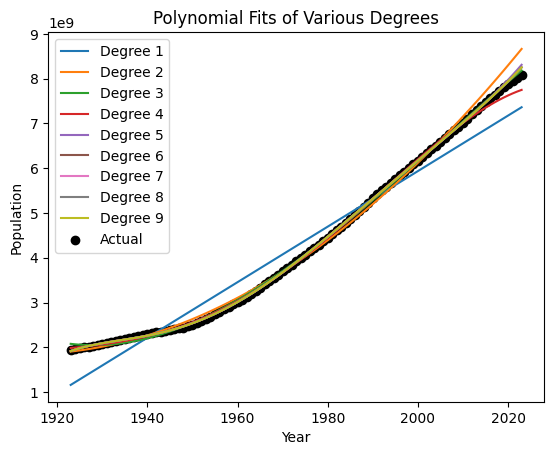

In [7]:
# -- Plot and Compare --

# Plot each degree for all the years
for degree in range(1, 10):
    poly = np.poly1d(fits[degree])
    population_fit = poly(years)
    
    plt.plot(years, population_fit, label=f'Degree {degree}')

plt.scatter(years, population, color='black', label='Actual') # Plot actual data as black dots

# Styling 
plt.legend()
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Polynomial Fits of Various Degrees')
plt.show()

In [14]:
# -- Model Testing --

# Calculate Residuals for each degree
residual_dict = {}    
for degree in range(1, 10):
    poly = np.poly1d(fits[degree])
    population_fit = poly(years_train)
    
    for i in range(0, len(years_train)):
        residual_dict[f'{degree}:{i}'] = population_fit[i] - population_train[i]
        

# Assume error bars of 1

# Calculate Chi-Squared Values for each degree 
chi_dict = {}
for degree in range(1, 10):
    chi = 0
    for key, r in residual_dict.items():
        if key.startswith(f'{degree}'):
             chi += r**2
    chi_dict[degree] = chi 



# Calculate Degree of Freedom Values for each degree
n_obs = len(years_train)
df_dict = {}
for degree in range(1, 10):
    df = n_obs - (degree + 1)
    df_dict[degree] = df
    
# Calculate chi squared per degrees of freedom f
chi_per_df_dict = {}
for degree in range(1, 10):
    chi = chi_dict[degree]
    df = df_dict[degree]
    chi_per_df = chi / df
    chi_per_df_dict[degree] = chi_per_df
    
    
    
# Calculate Byesian Information Criterion (BIC)
bic_dict = {}
for degree in range(1, 10):
    k = degree + 1 # number of parameters
    bic = chi_dict[degree] + k * np.log(n_obs) # logarithm for penalties
    bic_dict[degree] = bic

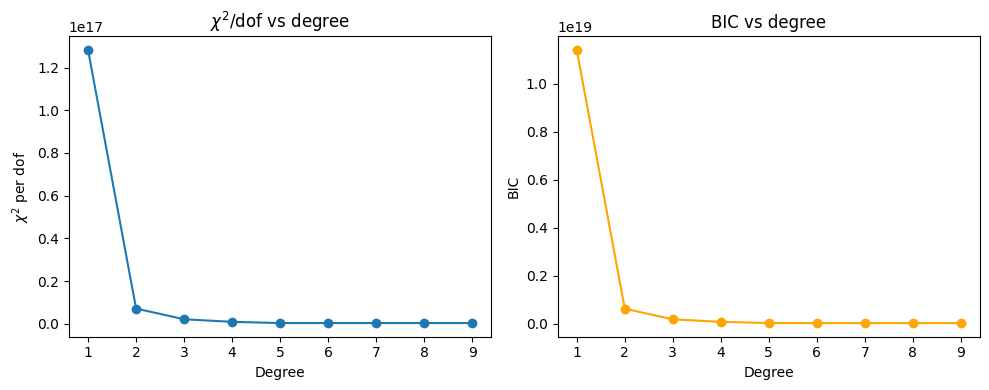

In [ ]:
degrees = np.arange(1, 10)

chi_per = [chi_per_df_dict[d] for d in degrees]
bics    = [bic_dict[d]        for d in degrees]

plt.figure(figsize=(10,4))

# Chi^2 per dof
plt.subplot(1,2,1)
plt.plot(degrees, chi_per, marker='o')
plt.xlabel('Degree')
plt.ylabel(r'$\chi^2$ per dof')
plt.title(r'$\chi^2$/dof vs degree')

# BIC
plt.subplot(1,2,2)
plt.plot(degrees, bics, marker='o', color='orange')
plt.xlabel('Degree')
plt.ylabel('BIC')
plt.title('BIC vs degree')


plt.tight_layout()
plt.show()
